In [6]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
import seaborn as sns
sns.set_theme(color_codes=True)
from scipy import stats
import statsmodels.api as sm
import numpy as np
import json

## Read the Data

In [8]:
first_session_raw_data = pd.read_csv('Data/first_round_data.csv', index_col=0).reset_index().drop(columns=['index'])
# first_session_raw_data = first_session_raw_data[first_session_raw_data.mturkID != 'nan' ]

num_all_experimenters = len(first_session_raw_data.mturkID.unique())
num_excluded_experimenters = 0

first_session_raw_data.head()

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,run_id,condition,rt,url,trial_type,trial_index,time_elapsed,internal_node_id,experiment_id,assignmentID,mturkID,hitID,exp_final_status,success,timeout,failed_images,failed_audio,failed_video,stimulus,response,exp_stage,view_history,exp_part,question_order,quiz_score,recorded_at,ip,user_agent,device,browser,browser_version,platform,platform_version,source_code_version,focus_screen,color,cond,cond_action,cond_outcome,block,side,x_circle,y_circle,choice,correct,curr_bonus,trial_bonus,outcome,feedback_points,prob_fall,expected_feedback,agg_fb_pts,error_block,num_gos,num_nogos,suspicious,hitId,workerId,assignmentId,a,tp_a,b,tp_b,c,tp_c,suspicious_type
0,115,1,7069,https://raw.githubusercontent.com/Sepsad/Ortho...,external-html,0,7223,0.0-0.0,GNG_jaokgw1e,35LDD5557B73ZRZ59T8367CD4KEMKS,A1AMGHYG5PT0L2,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,not_completed_by_failing_quiz,"""","""","""","""","""","""","""","""","""","""","""","""",2021-11-23 16:41:37,137.148.113.99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WebKit,Chrome,96.0.4664.45,Windows,10.0,ff253546778cd407e57361676f185c6a,focus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,A1AMGHYG5PT0L2,35LDD5557B73ZRZ59T8367CD4KEMKS,5DL57,5DL57,35LDD5557B73ZRZ59T8367CD4KEMKS,35LDD5557B73ZRZ59T8367CD4KEMKS,332327.0,332327.0,NaN
1,115,1,10702.699999809265,https://raw.githubusercontent.com/Sepsad/Ortho...,external-html,1,18151,0.0-1.0,GNG_jaokgw1e,35LDD5557B73ZRZ59T8367CD4KEMKS,A1AMGHYG5PT0L2,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,not_completed_by_failing_quiz,"""","""","""","""","""","""","""","""","""","""","""","""",2021-11-23 16:41:37,137.148.113.99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WebKit,Chrome,96.0.4664.45,Windows,10.0,ff253546778cd407e57361676f185c6a,"""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,A1AMGHYG5PT0L2,35LDD5557B73ZRZ59T8367CD4KEMKS,5DL57,5DL57,35LDD5557B73ZRZ59T8367CD4KEMKS,35LDD5557B73ZRZ59T8367CD4KEMKS,332327.0,332327.0,NaN
2,115,1,"""","""",preload,2,19590,0.0-2.0,GNG_jaokgw1e,35LDD5557B73ZRZ59T8367CD4KEMKS,A1AMGHYG5PT0L2,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,not_completed_by_failing_quiz,true,false,[],[],[],"""","""","""","""","""","""","""",2021-11-23 16:41:37,137.148.113.99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WebKit,Chrome,96.0.4664.45,Windows,10.0,ff253546778cd407e57361676f185c6a,"""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,A1AMGHYG5PT0L2,35LDD5557B73ZRZ59T8367CD4KEMKS,5DL57,5DL57,35LDD5557B73ZRZ59T8367CD4KEMKS,35LDD5557B73ZRZ59T8367CD4KEMKS,332327.0,332327.0,NaN
3,115,1,2415.5999999046326,"""",html-button-response,3,22007,0.0-3.0,GNG_jaokgw1e,35LDD5557B73ZRZ59T8367CD4KEMKS,A1AMGHYG5PT0L2,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,not_completed_by_failing_quiz,"""","""","""","""","""",<img src='../img/welcome.gif' style='height: 2...,0,first_welcome,"""","""","""","""",2021-11-23 16:41:37,137.148.113.99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WebKit,Chrome,96.0.4664.45,Windows,10.0,ff253546778cd407e57361676f185c6a,"""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,A1AMGHYG5PT0L2,35LDD5557B73ZRZ59T8367CD4KEMKS,5DL57,5DL57,35LDD5557B73ZRZ59T8367CD4KEMKS,35LDD5557B73ZRZ59T8367CD4KEMKS,332327.0,332327.0,NaN
4,115,1,8928.599999904633,"""",instructions,4,30936,0.0-4.0,GNG_jaokgw1e,35LDD5557B73ZRZ59T8367CD4KEMKS,A1AMGHYG5PT0L2,3WPCIUYH1BBXCWLM07IQZOHQYHJDTE,not_completed_by_failing_quiz,"""","""","""","""","""","""","""",before_instructions,"[{""page_index"":0,""viewing_time"":1983.5},{""page...",before_instructions,"""","""",2021-11-23 16:41:37,137.148.113.99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WebKit,Chrome,96.0.4664.45,Windows,10.0,ff253546778cd407e57361676f185c6a,"""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3WPCIUYH

# Apply exclusion criteria

1. Fail the quiz of instructions more than twice.
2. Change the tab or window of the experiment.

In [9]:
first_session_clean_data = first_session_raw_data[(first_session_raw_data.exp_final_status == 'fully_completed')]

num_excluded_experimenters = len(first_session_raw_data.mturkID.unique()) - len(first_session_clean_data.mturkID.unique())

print("Number of participants excluded by this criterias:", num_excluded_experimenters)

Number of participants excluded by this criterias: 8


3. Respond randomly, always go or never go.

    * Note: We exclude who repond randomly, always go or nogo in each 3 block

In [10]:
len(first_session_clean_data.mturkID.unique())

62

In [11]:
first_session_clean_data[first_session_clean_data.suspicious == 'true'][['mturkID', 'suspicious_type','num_gos', 'block']]

,mturkID,suspicious_type,num_gos,block
2201,A1FVXS8IM5QYO8,error_rate,33,block_2
13298,A1Y8BGDLPNYP0K,time_outs,0,block_1
13539,A1Y8BGDLPNYP0K,time_outs,0,block_2
13780,A1Y8BGDLPNYP0K,time_outs,0,block_3
16204,AQMLJYUQCSG22,error_rate,36,block_3
20007,A2G7F8S617H0BB,all_one,40,block_2
25096,A1SMVF4MXT0RIH,error_rate,38,block_3
31892,A68J20100VW4W,error_rate,39,block_1
39476,A27O7H19C0WQ7T,time_outs,0,block_1
39717,A27O7H19C0WQ7T,time_outs,0,block_2


In [12]:
IDs_for_exclusion_by_random_response = ['A1Y8BGDLPNYP0K', 'A27O7H19C0WQ7T']

num_excluded_experimenters += len(IDs_for_exclusion_by_random_response)

first_session_clean_data = first_session_clean_data[first_session_clean_data.isin(IDs_for_exclusion_by_random_response) == False]

print("Number of participants excluded by this criterias:", len(IDs_for_exclusion_by_random_response))


Number of participants excluded by this criterias: 2


4. Their rate of the correct response to detection of circle side task is less than 55%.

In [13]:
circle_side_correctness = first_session_clean_data[first_session_clean_data.choice == 'go'][['mturkID','side', 'response']]
circle_side_correctness['is_correct_circle_side'] =  (circle_side_correctness.side == circle_side_correctness.response)
accuracy_data = circle_side_correctness.groupby('mturkID').mean().reset_index()
accuracy_data.columns = ['mturkID', 'rate']
accuracy_data['is_below_55'] = accuracy_data.rate < 0.55

accuracy_data.head()


,mturkID,rate,is_below_55
0,A12FTSX85NQ8N9,0.895833,False
1,A1BNGJBEWJS8WE,0.544444,True
2,A1CY7IOJ9YH136,1.000000,False
3,A1DZMZTXWOM9MR,1.000000,False
4,A1FVXS8IM5QYO8,0.788991,False


In [14]:
non_accurate_IDs = accuracy_data[accuracy_data.is_below_55].mturkID

num_excluded_experimenters += len(non_accurate_IDs)

first_session_clean_data = first_session_clean_data[first_session_clean_data.isin(list(non_accurate_IDs)) == False]
print("Number of participants excluded by this criterias:", len(non_accurate_IDs))



Number of participants excluded by this criterias: 13


In [15]:
for i in list(non_accurate_IDs):
    print(i)

A1BNGJBEWJS8WE
A1SMVF4MXT0RIH
A1USR9JCAMDGM3
A1ZRK6K5JUPJAV
A2683ZVNWI119A
A271830PNYAI2G
A2G7F8S617H0BB
A2M183CETUMR96
A2NA6X1SON3KFH
A3ITZNJQUTIZ4C
A68J20100VW4W
AQMLJYUQCSG22
AUQ79MANVDU9B


# Plot Perforance per conditions

/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_21257/1135958102.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)


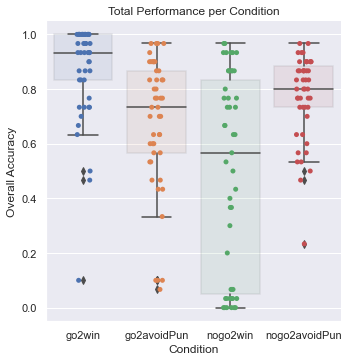

In [16]:
mapping = {'1': 'go2win', '2': 'nogo2win', '3': 'go2avoidPun', '4' : 'nogo2avoidPun'} 

circle_task_logs = first_session_clean_data[first_session_clean_data.exp_stage == 'main_target_detection']

circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)
performance_per_condition = circle_task_logs.groupby(['mturkID','cond']).mean().reset_index()
performance_per_condition.cond = performance_per_condition.cond.map(mapping)

ax = sns.catplot(x="cond", y="correct", data=performance_per_condition, order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);
ax = sns.boxplot(x="cond", y="correct", data= performance_per_condition, boxprops=dict(alpha=.1), order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);

ax.set(xlabel="Condition", ylabel = "Overall Accuracy", title = 'Total Performance per Condition')
plt.show()


# Extract demographic data

In [21]:
raw_demographic_data = first_session_clean_data[first_session_clean_data.trial_type == 'survey-html-form'][['mturkID', 'response']]
raw_demographic_data['gender'] = raw_demographic_data.response.apply(lambda x: x.split('"')[3])
raw_demographic_data['age'] = raw_demographic_data.response.apply(lambda x: x.split('"')[7])
raw_demographic_data['education_level'] = raw_demographic_data.response.apply(lambda x: x.split('"')[11])
raw_demographic_data['comments'] = raw_demographic_data.response.apply(lambda x: x.split('"')[15])
raw_demographic_data = raw_demographic_data.drop(['response'], axis=1)
raw_demographic_data.head()

,mturkID,gender,age,education_level,comments
816,AD1WGUMVD6KED,female,39,High,Everything was straight forward and ran smooth...
1623,A8028AFBBS29G,female,66,High,Yes I wanted to remember which to push and whi...
2443,A1FVXS8IM5QYO8,female,55,High,This was a really interesting task
3250,A2NAKIXS3DVGAA,male,27,Bachelor,}
4057,A353XKDTUX10NC,male,27,High,}


# Create final data to analyze

In [32]:
final_performace_data = performance_per_condition.pivot(index='mturkID', columns='cond', values='correct').reset_index()

final_performace_data = pd.merge(final_performace_data, accuracy_data, on='mturkID', how='left')
final_performace_data = pd.merge(final_performace_data, raw_demographic_data, on='mturkID')
final_performace_data.columns = ['mturkID', 'go2avoidPun_first_session', 'go2win_first_session', 'nogo2avoidPun_first_session', 'nogo2win_first_session', 'circle_side_performance_first_session',\
       'is_below_55_first_session', 'gender_first_session', 'age_first_session', 'education_level_first_session', 'comments_first_session']

final_performace_data.head()

,mturkID,go2avoidPun_first_session,go2win_first_session,nogo2avoidPun_first_session,nogo2win_first_session,circle_side_performance_first_session,is_below_55_first_session,gender_first_session,age_first_session,education_level_first_session,comments_first_session
0,A12FTSX85NQ8N9,0.566667,0.500000,0.866667,0.866667,0.895833,False,male,29,Bachelor,}
1,A1CY7IOJ9YH136,0.533333,0.966667,0.500000,0.366667,1.000000,False,female,52,Bachelor,}
2,A1DZMZTXWOM9MR,0.900000,1.000000,0.900000,0.933333,1.000000,False,male,39,High,I do not have any comments that I'd like to ad...
3,A1FVXS8IM5QYO8,0.533333,0.700000,0.233333,0.033333,0.788991,False,female,55,High,This was a really interesting task
4,A1MJVTR0PCKBWW,0.466667,0.633333,0.700000,0.733333,0.847458,False,female,26,Bachelor,"everything worked fine, I had no issues"


In [33]:
final_performace_data.to_csv('Data/first_round_final_performance.csv')

